In [66]:
from flax import linen as nn
import jax
import jax.numpy as jnp
import optax
import numpy as np
import tensorflow_datasets as tfds
from typing import Sequence
import time
from tqdm.auto import tqdm

# Show on which platform JAX is running.
print("JAX running on", jax.devices()[0].platform.upper())

# The learning rate for the optimizer:
LEARNING_RATE = 1e-4

# Number of samples in each batch:
BATCH_SIZE = 1000

# Total number of epochs to train for:
N_EPOCHS = 20

# Population size for evolutionary algorithm
POPULATION_SIZE = 10000

(train_loader, test_loader), info = tfds.load(
        'mnist', split=["train", "test"], as_supervised=True, with_info=True
)
NUM_CLASSES = info.features["label"].num_classes
IMG_SIZE = info.features["image"].shape

train_loader_batched = train_loader.shuffle(
        buffer_size=10_000, reshuffle_each_iteration=True
).batch(BATCH_SIZE, drop_remainder=True)

test_loader_batched = test_loader.batch(BATCH_SIZE, drop_remainder=True)

class MLP(nn.Module):
    """A simple multilayer perceptron model for image classification."""
    hidden_sizes: Sequence[int] = (20,)

    @nn.compact
    def __call__(self, x):
        # Flattens images in the batch.
        x = x.reshape((x.shape[0], -1))
        for size in self.hidden_sizes:
                x = nn.Dense(features=size)(x)
                x = nn.relu(x)
        x = nn.Dense(features=NUM_CLASSES)(x)
        return x

@jax.jit
def predict(params, inputs):
    return net.apply({'params': params}, inputs)

@jax.jit
def loss_accuracy(params, data):
    """Computes loss and accuracy over a mini-batch.

    Args:
        params: parameters of the model.
        bn_params: state of the model.
        data: tuple of (inputs, labels).
        is_training: if true, uses train mode, otherwise uses eval mode.

    Returns:
        loss: float
    """
    inputs, labels = data
    logits = predict(params, inputs)
    loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=labels
    ).mean()
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
    return loss, accuracy

@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

def dataset_stats(params, data_loader):
    """Computes loss and accuracy over the dataset `data_loader`."""
    all_accuracy = []
    all_loss = []
    for batch in data_loader.as_numpy_iterator():
        batch_loss, batch_aux = loss_accuracy(params, batch)
        all_loss.append(batch_loss)
        all_accuracy.append(batch_aux)
    return {"loss": np.mean(all_loss), "accuracy": np.mean(all_accuracy)}

net = MLP()

solver_1 = optax.sgd(LEARNING_RATE, momentum = 0.9, nesterov = True)
rng = jax.random.PRNGKey(0)
dummy_data = jnp.ones((1,) + IMG_SIZE, dtype=jnp.float32)

init_params = net.init({"params": rng}, dummy_data)["params"]

methods = ["Evolutionary Strategy", "SGD"]
metrics = dict.fromkeys(methods)

for method in methods:
        metrics[method] = dict.fromkeys(["Train loss", "Test loss",
                                        "Train accuracy", "Test accuracy",
                                        "Time"])

        for key in metrics[method]:
            metrics[method][key] = []

def evaluate_model(params, metrics, method):
    metr = dataset_stats(params, train_loader_batched)
    metrics[method]["Train loss"].append(metr["loss"])
    metrics[method]["Train accuracy"].append(metr["accuracy"])

    metr = dataset_stats(params, test_loader_batched)
    metrics[method]["Test loss"].append(metr["loss"])
    metrics[method]["Test accuracy"].append(metr["accuracy"])

    return metrics

@jax.jit
def grad_step(params, solver_state, batch):
    # Performs a one step update.
    (loss, aux), grad = jax.value_and_grad(loss_accuracy, has_aux=True)(
            params, batch
    )
    updates, solver_state = solver_1.update(grad, solver_state, params)
    params = optax.apply_updates(params, updates)
    return params, solver_state, loss, aux

@jax.jit
def add_noise(params, key, noise_scale=1e-3):
    # Function to add Gaussian noise to parameters, handling a single key
    return jax.tree_map(lambda p: p + noise_scale * jax.random.normal(key, p.shape, p.dtype), params)

def grad_free_step(params, batch, num_samples=POPULATION_SIZE, noise_scale=1e-3):
    keys = jax.random.split(jax.random.PRNGKey(0), num_samples)

    # Vectorize the add_noise function over the keys
    batched_add_noise = jax.vmap(add_noise, in_axes=(None, 0, None))
    noisy_params_list = batched_add_noise(params, keys, noise_scale)

    # Vectorized loss calculation
    vectorized_loss_accuracy = jax.vmap(loss_accuracy, in_axes=(0, None))
    losses, accs = vectorized_loss_accuracy(noisy_params_list, batch)

    # Find the index of parameters with the lowest loss
    best_index = jnp.argmin(losses)
    best_params = jax.tree_map(lambda p: p[best_index], noisy_params_list)

    # Extract the corresponding loss and accuracy
    best_loss = losses[best_index]
    best_acc = accs[best_index]

    prev_loss, prev_acc = loss_accuracy(params, batch)

    if best_loss <= prev_loss:
        # print(f"Found better {prev_loss} -> {best_loss}")
        return best_params, best_loss, best_acc
    else:
        # print("Remain the same")
        return params, prev_loss, prev_acc

for method in methods:
    ### Evaluate model before training
    params = init_params
    metrics = evaluate_model(params, metrics, method)
    metrics[method]["Time"].append(0)

    if method == "SGD":
        solver_state = solver_1.init(init_params)
        start_time = time.time()
        for epoch in range(N_EPOCHS):
            train_accuracy_epoch = []
            train_losses_epoch = []

            for train_batch in train_loader_batched.as_numpy_iterator():
                params, solver_state, train_loss, train_acc = grad_step(
                        params, solver_state, train_batch
                )
                metrics[method]["Train loss"].append(train_loss)
                metrics[method]["Train accuracy"].append(train_acc)

            metrics[method]["Time"].append(time.time() - start_time)

            metrics = evaluate_model(params, metrics, method)
    elif method == "Evolutionary Strategy":
        params = init_params
        start_time = time.time()
        for epoch in tqdm(range(N_EPOCHS)):
            noise = (1 - epoch/N_EPOCHS)*7e-3

            for train_batch in train_loader_batched.as_numpy_iterator():
                params, train_loss, train_acc = grad_free_step(
                        params, train_batch, noise_scale = noise
                )
                metrics[method]["Train loss"].append(train_loss)
                metrics[method]["Train accuracy"].append(train_acc)

            metrics[method]["Time"].append(time.time() - start_time)
            metrics = evaluate_model(params, metrics, method)

JAX running on GPU


  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-72-597ac7f480cd>:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


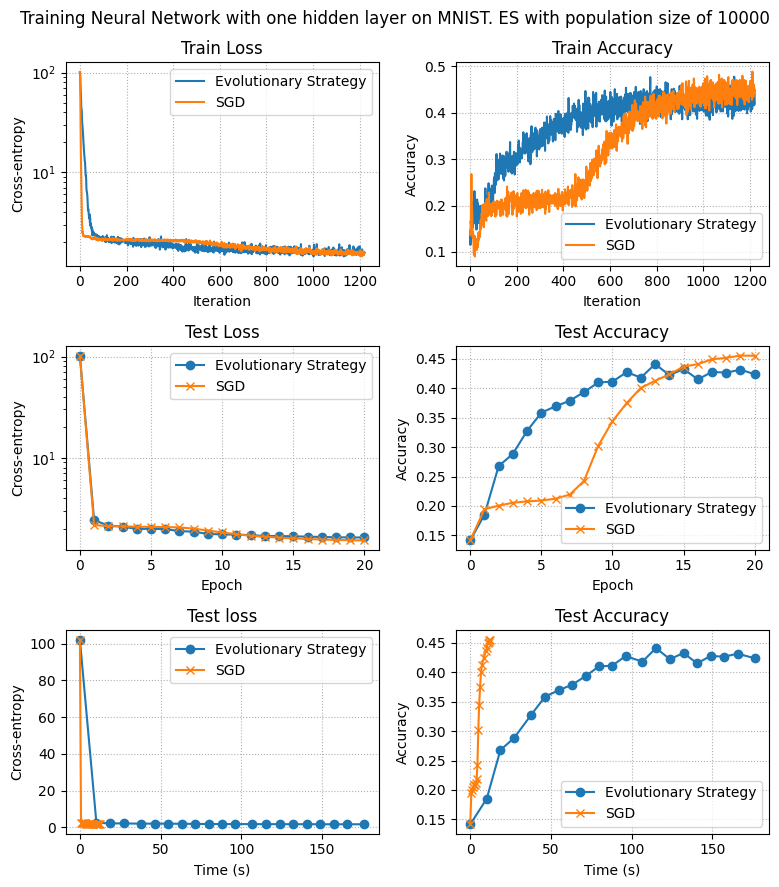

In [72]:
# Modifying the code to add different markers to the epoch graphs for each method

# Creating a mosaic layout
fig, axs = plt.subplot_mosaic([['A', 'C'],
                               ['B', 'D'],
                               ["E", "F"]],
                              figsize=(8, 9), constrained_layout=True)

# Assuming 'methods' and 'metrics' are defined and contain the required data
# Plotting the graphs in the specified layout with different markers for each method

# Train Loss
for method in methods:
    axs['A'].semilogy(metrics[method]["Train loss"], label=method)
axs['A'].set_title("Train Loss")
axs['A'].set_xlabel("Iteration")
axs['A'].set_ylabel("Cross-entropy")
axs['A'].legend()
axs['A'].grid(linestyle=":")

# Test Loss
for method in methods:
    marker = 'x' if method == "SGD" else 'o'  # 'x' for SGD, 'o' for ES
    axs['B'].semilogy(metrics[method]["Test loss"], label=method, marker=marker)
axs['B'].set_title("Test Loss")
axs['B'].set_xlabel("Epoch")
axs['B'].set_ylabel("Cross-entropy")
axs['B'].legend()
axs['B'].grid(linestyle=":")

# Train Accuracy
for method in methods:
    axs['C'].plot(metrics[method]["Train accuracy"], label=method)
axs['C'].set_title("Train Accuracy")
axs['C'].set_xlabel("Iteration")
axs['C'].set_ylabel("Accuracy")
axs['C'].legend()
axs['C'].grid(linestyle=":")

# Test Accuracy
for method in methods:
    marker = 'x' if method == "SGD" else 'o'  # 'x' for SGD, 'o' for ES
    axs['D'].plot(metrics[method]["Test accuracy"], label=method, marker=marker)
axs['D'].set_title("Test Accuracy")
axs['D'].set_xlabel("Epoch")
axs['D'].set_ylabel("Accuracy")
axs['D'].legend()
axs['D'].grid(linestyle=":")

# Train Epoch from Time
for method in methods:
    marker = 'x' if method == "SGD" else 'o'  # 'x' for SGD, 'o' for ES
    axs['E'].plot(metrics[method]["Time"], metrics[method]["Test loss"], label=method, marker=marker)
axs['E'].set_title("Test loss")
axs['E'].set_xlabel("Time (s)")
axs['E'].set_ylabel("Cross-entropy")
axs['E'].legend()
axs['E'].grid(linestyle=":")

# Test Accuracy from Time
for method in methods:
    marker = 'x' if method == "SGD" else 'o'  # 'x' for SGD, 'o' for ES
    axs['F'].plot(metrics[method]["Time"], metrics[method]["Test accuracy"], label=method, marker=marker)
axs['F'].set_title("Test Accuracy")
axs['F'].set_xlabel("Time (s)")
axs['F'].set_ylabel("Accuracy")
axs['F'].legend()
axs['F'].grid(linestyle=":")

plt.suptitle(f"Training Neural Network with one hidden layer on MNIST. ES with population size of {POPULATION_SIZE}")
plt.tight_layout()
plt.savefig("ES_vs_SGD.svg")
plt.show()